# Introduction

In this tutorial, we introduce the qflow package and its building blocks to optimize a variational quantum circuit. We start by loading a Hamiltonian that represents the objective function we want to minimize. We use the molecular Hamiltonians for our examples. We also select a circuit template from the package, and for demonstration purposes, we chose the MolecularBasicEntangler ansatz. Then we will see how we can minimize the energy of the molecule by optimizing the circuit parameters. We will also see how we can use the package to generate a circuit diagram of the ansatz.

To summarize: 

1. Load a Hamiltonian, H.
2. Load a circuit template $\ket{\psi(\theta)}$ given a Hamiltonian, H.
2. Wrap both the Hamiltonian, H and the circuit template $\ket{\psi(\theta)}$ into a [QNode](https://docs.pennylane.ai/en/stable/code/api/pennylane.QNode.html), to generate an executable function that returns e.g. the expecation value $\bra{\psi(\theta)} H \ket{\psi(\theta)}$.
3. Select an optimizer and start minimizing.


![VQA](libs/qflow/resources/figures/workflow.png)

In [1]:
import numpy as np
import pennylane as qml
from pennylane import AdamOptimizer, QNGOptimizer, GradientDescentOptimizer
from tqdm import tqdm
import pennylane.numpy as pnp
from dataclasses import dataclass
from qflow.utils.utils import get_approximation_ratio
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Hamiltonians

For every variatonal quantum algorithm we need a Hamiltonian. The Hamiltonian is the objective function we want to minimize. In the case of ground state estimation we want to find the ground state of the Hamiltonian.

In [2]:
from qflow.hamiltonian import get_h2o_hamiltonian, get_lih_hamiltonian, get_h4_hamiltonian

H, num_qubits, min_energy,_,_ = get_h4_hamiltonian()
# H, num_qubits, min_energy,_,_ = get_lih_hamiltonian()
# H, num_qubits, min_energy,_,_ = get_h2o_hamiltonian()

converged SCF energy = -1.48812651954926


## Circuit template

A circuit template comprises an executable circuit, wires or the number of qubits, and an init() method that returns the parameters to optimize. The init() method can be seeded for reproducibility.

For this tutorial, we have selected the MolecularBasicEntangler circuit ansatz as our circuit template. This variational circuit can prepare our trial state $\ket{\psi(\theta)}$.

In [3]:
from qflow.templates.circuits import MolecularBasicEntangler, MolecularStrongEntangler

initial_state = pnp.array([1, 1, 1, 1, 0, 0, 0, 0])

circuit = MolecularBasicEntangler(num_layers=1, wires=range(num_qubits), initial_state=initial_state)
params = circuit.init()


## Import preset examples for the Molecular Hamiltonian

For convenience, we provide several preset examples in the `qflow.templates.examples` module. These examples include pre-selected circuits and Hamiltonians, which can make it easier to get started with the library. 

We provide examples for LiH, H2O, H4, QAOA applied to maxcut, etc.

For example, you can load the `h4_vqe_basic_entangler_example` example to quickly set up a circuit and Hamiltonian.

In [4]:
from qflow.templates.examples import lih_vqe_basic_entangler_example, lih_vqe_strong_entangler_example, h2o_vqe_basic_entangler_example, h2o_vqe_strong_entangler_example, h4_vqe_basic_entangler_example, h4_vqe_strong_entangler_example, maxcut_qaoa_example

# circuit, H, min_energy = h4_vqe_basic_entangler_example(num_layers=1)
circuit, H, min_energy = maxcut_qaoa_example(num_layers=3, num_nodes=4)

params = circuit.init()


/Users/davidfitzek/miniforge3/envs/test/lib/python3.10/site-packages/pennylane/utils.py:67: UserWarning: The method sparse_hamiltonian is deprecated. Please use the method sparse_matrix of the Hamiltonian operator instead.
  warnings.warn(


In [5]:
print(qml.draw(circuit)(params))

0: ──H─╭ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,2.32)
1: ──H─├ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,2.32)
2: ──H─├ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,2.32)
3: ──H─╰ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,2.32)

──╭ApproxTimeEvolution(1.00,1.00,1.00,1.00,2.88)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,2.88)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,2.88)
──╰ApproxTimeEvolution(1.00,1.00,1.00,1.00,2.88)

──╭ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,1.18)
──├ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,1.18)
──├ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,1.18)
──╰ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,1.18)

──╭ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.93)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.93)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.93)
──╰ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.93)

──╭ApproxTimeEvolution(0.50,0.50,0.50,0.50,0.50,-2.50,4.50)
──├ApproxTimeEvolution(0.50,0.50,0.50,0.50,0

## Creating a loss function for optimization

After setting up the circuit and the Hamiltonian, we need to define a loss function to be optimized during the training process. The objective of the loss function is to calculate the expectation value of a specific observable, such as the Hamiltonian, with respect to the trial state prepared by the circuit. The expectation value is obtained by evaluating the inner product of the trial state and the observable, and is commonly expressed as $\langle \psi(\theta) \vert H \vert \psi(\theta) \rangle$.

In [6]:
dev = qml.device("default.qubit", wires=circuit.wires)


@qml.qnode(dev)
def loss_fn(params):
    circuit(params)
    return qml.expval(H)

## Optimizing the circuit

Let's optimize the circuit! To do this, we need to create a loop that iterates between the classical optimizer and the quantum circuit. We'll define some variables to track our progress along the way.

In [7]:
stepsize= 0.05
steps = 100
seed = 0

In [8]:
@dataclass
class Datapoint:
    step: int
    exp_val: float
    optimizer: str

In [9]:
list_optimizer = [
    GradientDescentOptimizer(stepsize=stepsize),
    AdamOptimizer(stepsize=stepsize),
    QNGOptimizer(stepsize=stepsize),
]

In [10]:
dataset = []
for optimizer in list_optimizer:
    optimizer_id = optimizer.__class__.__name__
    print(optimizer_id)
    params = circuit.init(seed)

    for k in tqdm(range(0, steps + 1)):
        params, exp_val = optimizer.step_and_cost(loss_fn, params)
        dataset.append(Datapoint(k, np.real(exp_val), optimizer_id))

    del optimizer


GradientDescentOptimizer


100%|██████████| 101/101 [00:02<00:00, 50.43it/s]


AdamOptimizer


100%|██████████| 101/101 [00:01<00:00, 52.01it/s]


QNGOptimizer


100%|██████████| 101/101 [00:09<00:00, 10.44it/s]


In [11]:
r = get_approximation_ratio(exp_val, min_energy, 0)
print(f"Approximation ratio: {np.round(r, 3)}")

Approximation ratio: (0.949-0j)


In [12]:
df = pd.DataFrame(
    columns=[
        "step",
        "exp_val",
        "optimizer",
    ]
)

df = pd.DataFrame([x.__dict__ for x in dataset])
df["exp_val"] = df["exp_val"].astype(float) 

/Users/davidfitzek/miniforge3/envs/test/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


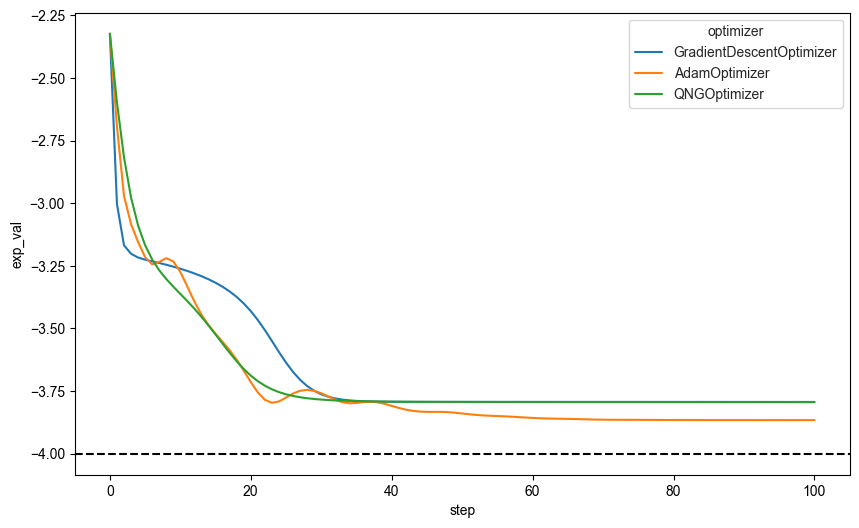

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("white")

g = sns.lineplot(
    x="step",
    y="exp_val",
    hue="optimizer",
    data=df,
    ax=ax,
)

ax.axhline(y=min_energy, color="black", linestyle="--", label="Ground state")

## Conclusion 

In this tutorial, we have demonstrated the basic workflow of optimizing a variational quantum circuit to estimate the ground state energy of a molecular Hamiltonian. We loaded the Hamiltonian, selected a quantum circuit ansatz, and wrapped it into a QNode to calculate the energy of the system. We then optimized the circuit parameters using various gradient-based  optimization methods.